In [24]:
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.coordinates.matrix_utilities import rotation_matrix
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from scipy.special import logsumexp
from scipy.stats import truncnorm
import emcee

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.mpl_style

from coordinates import (pal5_c, galcen_frame, 
                         pal5_lead_frame, pal5_trail_frame)

In [25]:
#### Added by SP to load sims ####

#Normal MW pot
#ra_sim = np.loadtxt('pot_MW14_q094_ra.txt')
#dec_sim = np.loadtxt('pot_MW14_q094_dec.txt')

# #Flattened MW pot
# ra_sim= np.loadtxt('pot_MW14_q094_ra.txt')
# dec_sim = np.loadtxt('pot_MW14_q094_dec.txt')

# #Barred pots
# ra_sim = np.loadtxt('pot_bar_M5e9_Om42_ra.txt')
# dec_sim = np.loadtxt('pot_bar_M5e9_Om42_dec.txt')

# ra_sim = np.loadtxt('pot_bar_M5e9_Om58_ra.txt')
# dec_sim = np.loadtxt('pot_bar_M5e9_Om58_dec.txt')

# ra_sim = np.loadtxt('pot_bar_M1e10_Om38_ra.txt')
# dec_sim = np.loadtxt('pot_bar_M1e10_Om38_dec.txt')

ra_sim = np.loadtxt('pot_bar_M1e10_Om41_ra.txt')
dec_sim = np.loadtxt('pot_bar_M1e10_Om41_dec.txt')


In [26]:

# TODO: load simulation data (sky position ra, dec):
# c = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg)
c = coord.SkyCoord(ra=ra_sim*u.deg, dec=dec_sim*u.deg)



#run sims and load here... or output sims to file 


In [27]:
c_l = c.transform_to(pal5_lead_frame)
c_t = c.transform_to(pal5_trail_frame)

In [28]:
Xl = np.stack((c_l.phi1.wrap_at(180*u.deg).degree,
               c_l.phi2.degree)).T

Xt = np.stack((c_t.phi1.wrap_at(180*u.deg).degree,
               c_t.phi2.degree)).T

# Width along stream

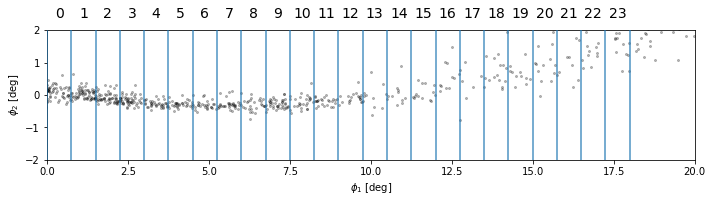

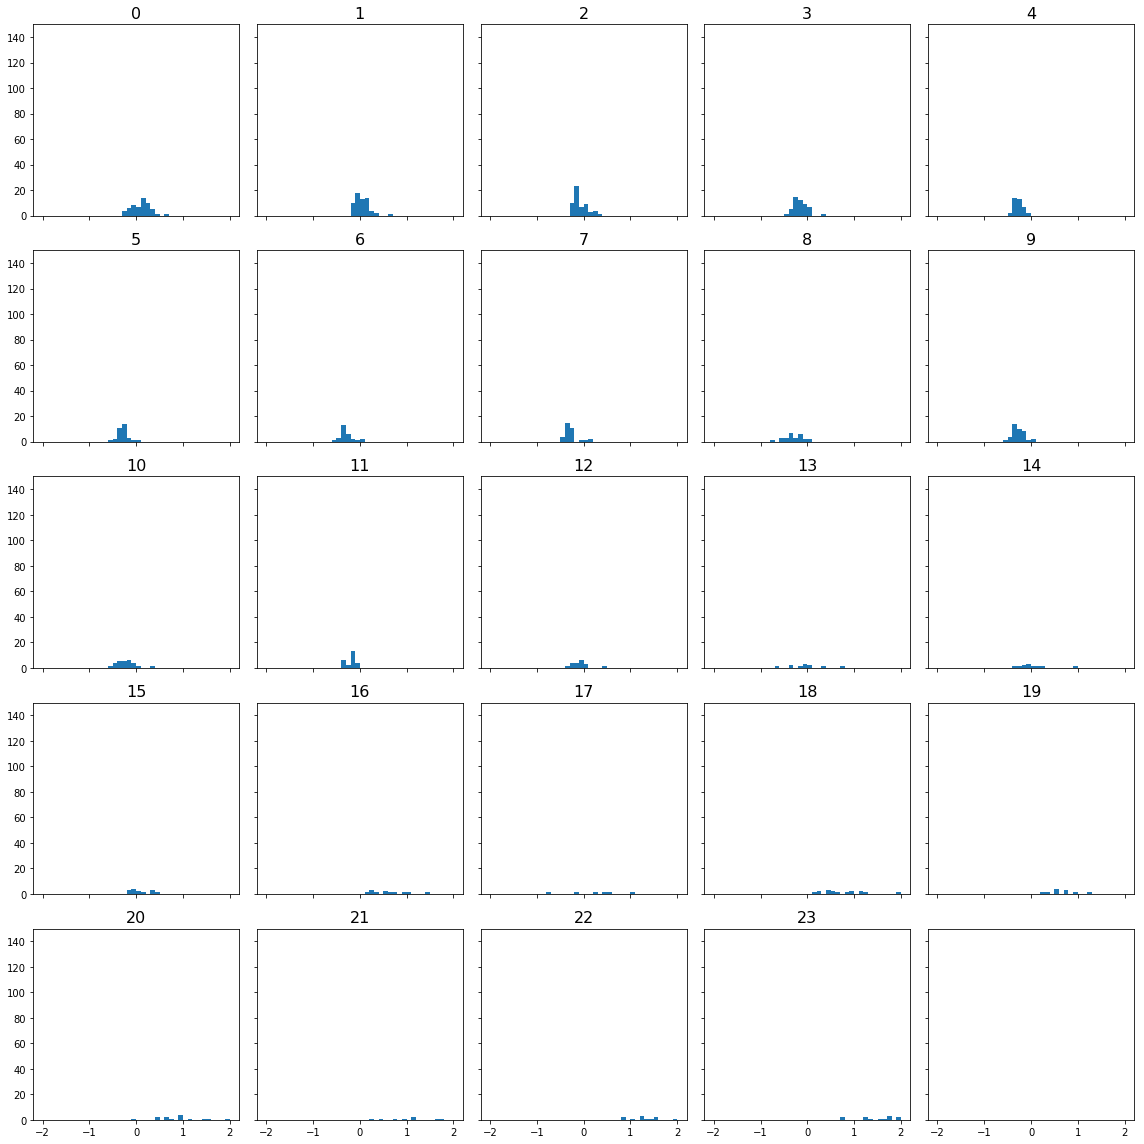

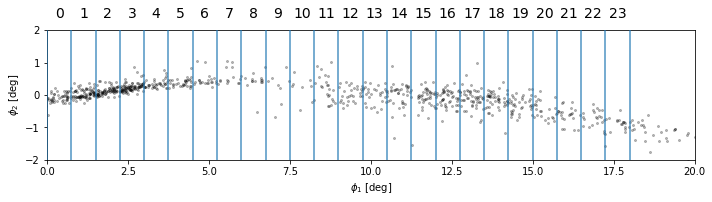

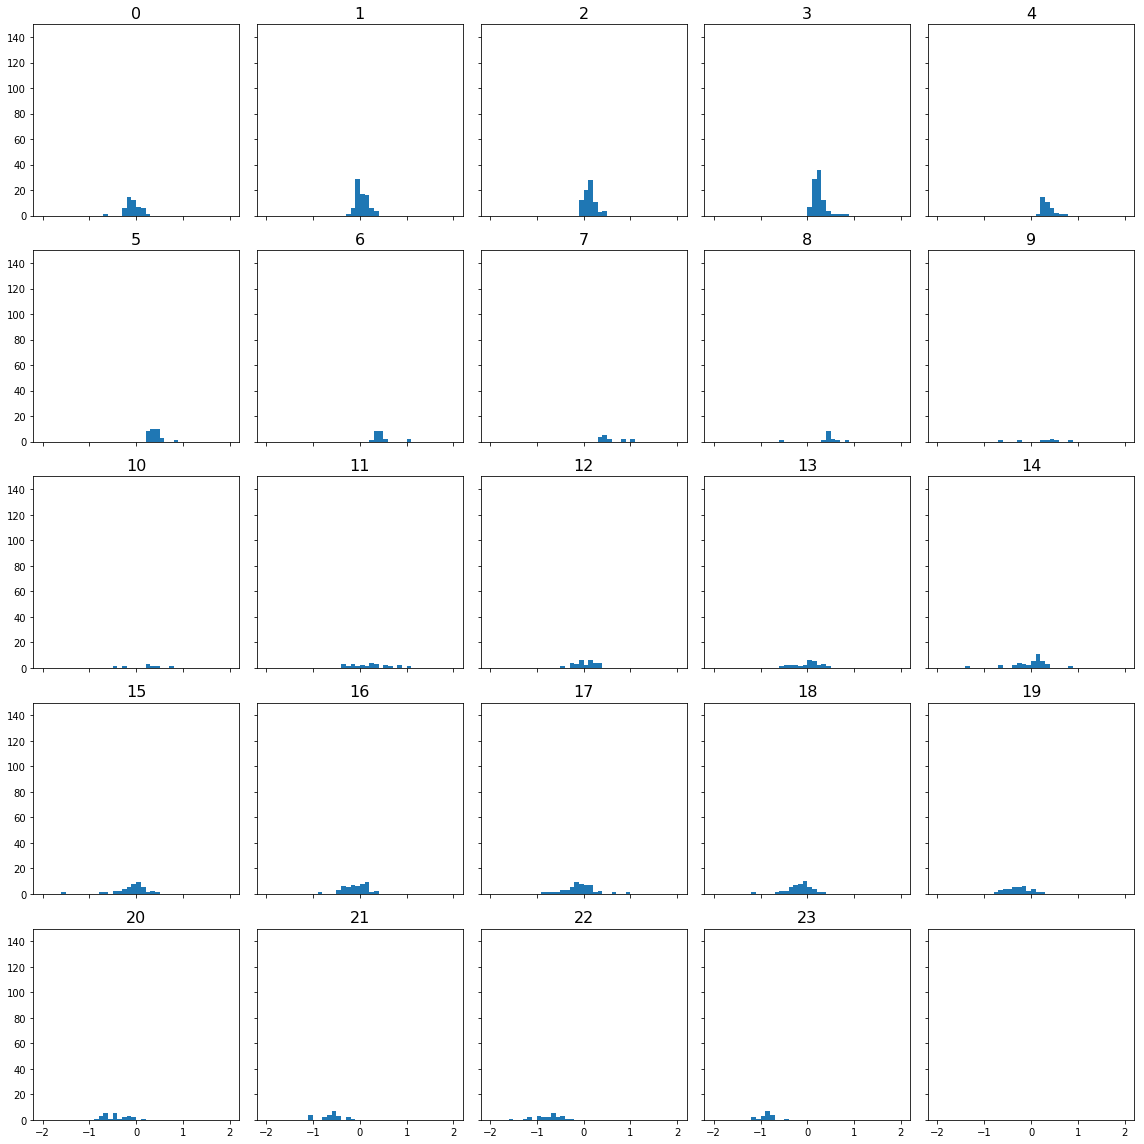

In [29]:
phi1_bins = np.arange(0, 18+1e-3, 0.75)
phi2_bins = np.arange(-2, 2+1e-3, 0.1)

# ---

for X in [Xl, Xt]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    ax.plot(X[:, 0], X[:, 1],
            marker='o', ls='none', 
            color='k', alpha=0.25, ms=2)

    for l in phi1_bins:
        ax.axvline(l, marker='', zorder=10, 
                   color='tab:blue', alpha=0.8)

    for i, l, r in zip(range(len(phi1_bins)), phi1_bins[:-1], phi1_bins[1:]):
        ax.text(0.5*(l+r), 2.5, str(i), fontsize=14, 
                ha='center', va='center')

    ax.set_xlim(0, 20.)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$\phi_1$ [deg]')
    ax.set_ylabel(r'$\phi_2$ [deg]')

    fig.tight_layout()
    fig.set_facecolor('w')

    # ---

    fig, axes = plt.subplots(5, 5, figsize=(16, 16),
                             sharex=True, sharey=True)

    for i, l, r in zip(range(len(phi1_bins)-1), 
                       phi1_bins[:-1], 
                       phi1_bins[1:]):
        phi1_mask = (X[:, 0] >= l) & (X[:, 0] <= r)
        ax = axes.flat[i]

        ax.hist(X[phi1_mask, 1], 
                bins=phi2_bins)
        ax.set_title(str(i), fontsize=16)

        ax.set_ylim(0, 150)

    fig.set_facecolor('w')
    fig.tight_layout()

In [30]:
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def ln_truncnorm(x, mu, sigma, clip_a, clip_b):
    a, b = (clip_a - mu) / sigma, (clip_b - mu) / sigma
    return truncnorm.logpdf(x, a, b, loc=mu, scale=sigma)

# 1 gaussian:
param_names = ['mu_s', 'lnstd_s']

def lnprior(p):
    mu_s, lnstd_s = p
    
    lp = 0
    
    lp += ln_truncnorm(mu_s, 0, 1, -1, 1)
    lp += ln_truncnorm(lnstd_s, -0.5, 1, -2.5, 1.5)
    
    return lp

def lnlike(p, phi2):
    mu_s, lnstd_s = p
    return lnnormal(phi2, mu_s, np.exp(lnstd_s))

def lnprob(p, phi2):
    lp = lnprior(p)
    if not np.all(np.isfinite(lp)):
        return -np.inf
    
    ll = lnlike(p, phi2).sum()
    if not np.all(np.isfinite(ll)):
        return -np.inf
    
    return ll + lp

In [31]:
nwalkers = 64
nburn = 128
nsteps = 256

In [ ]:
phi2_min = -2.
phi2_max = 2.

data = dict()
for name, X, _phi1_bins in zip(['lead', 'trail'], 
                               [Xl, Xt], 
                               [phi1_bins[:14], phi1_bins[:23]]):
    phi2_mask = (X[:, 1] > phi2_min) & (X[:, 1] < phi2_max)

    all_samplers = []
    Ns = []
    for i, l, r in zip(range(len(phi1_bins)-1), 
                       _phi1_bins[:-1], 
                       _phi1_bins[1:]):
            
        phi1_mask = (X[:, 0] > l) & (X[:, 0] <= r)
        binX = X[phi1_mask & phi2_mask]
        Ns.append((phi1_mask & phi2_mask).sum())

        H, _ = np.histogram(binX[:, 1], bins=phi2_bins)
        phi2_bin_c = 0.5*(phi2_bins[:-1]+phi2_bins[1:])
        mu = phi2_bin_c[H.argmax()]
        if np.abs(mu) > 1.:
            mu = 0.
        
        # for 1-component gaussian
        p0 = (mu, np.log(0.1))

        p0s = emcee.utils.sample_ball(p0, [1e-3]*len(p0), nwalkers)

        sampler = emcee.EnsembleSampler(nwalkers, len(p0), 
                                        log_prob_fn=lnprob, 
                                        args=(binX[:, 1], ))

        pos,*_ = sampler.run_mcmc(p0s, nburn, progress=True)
        pos = emcee.utils.sample_ball(np.median(pos, axis=0), 
                                      [1e-3]*len(p0), nwalkers)
        # sampler.reset()
        # _ = sampler.run_mcmc(pos, nburn, progress=True)
        sampler.reset()
        pos,*_ = sampler.run_mcmc(pos, nburn, progress=True)
        sampler.reset()
        _ = sampler.run_mcmc(pos, nsteps, progress=True)
        print()
        
        all_samplers.append(sampler)
    
    data[name] = dict()
    data[name]['X'] = X
    data[name]['samplers'] = all_samplers
    data[name]['phi1_bins'] = _phi1_bins
    data[name]['N'] = np.array(Ns)

  3%|▎         | 4/128 [00:00<00:03, 37.96it/s]

  5%|▍         | 6/128 [00:00<00:02, 55.73it/s]

  5%|▍         | 6/128 [00:00<00:02, 55.47it/s]

 20%|█▉        | 50/256 [00:00<00:04, 50.74it/s]

In [ ]:
# sampler = data['lead']['samplers'][2]
# sampler = data['trail']['samplers'][9]
# sampler = data['lead']['samplers'][0]

# fig, axes = plt.subplots(sampler.ndim, 1, figsize=(8, 2*sampler.ndim),
#                          sharex=True)
# for k in range(sampler.ndim):
#     for walker in sampler.chain[..., k]:
#         axes[k].plot(walker, marker='', drawstyle='steps-mid', 
#                      color='k', alpha=0.2)
        
# fig.tight_layout()

In [ ]:
flatchains = dict()
for name in data:
    all_flatchains = []
    for sampler in data[name]['samplers']:
        all_flatchains.append(sampler.flatchain)

    all_flatchains = np.array(all_flatchains)
    
    flatchains[name] = Table()
    for k, par in enumerate(param_names):
        if par.startswith('ln_'):
            flatchains[name][par] = all_flatchains[..., k]
            flatchains[name][par[3:]] = np.exp(all_flatchains[..., k])
        elif par.startswith('ln'):
            flatchains[name][par] = all_flatchains[..., k]
            flatchains[name][par[2:]] = np.exp(all_flatchains[..., k])
        else:
            flatchains[name][par] = all_flatchains[..., k]
            
    phi1_bin_c = 0.5 * (data[name]['phi1_bins'][:-1] + data[name]['phi1_bins'][1:]) * u.deg
    flatchains[name]['phi1_bin_c'] = phi1_bin_c
    flatchains[name]['N'] = data[name]['N']

In [ ]:
fig = plt.figure(figsize=(8,4))

for name in data.keys():
    flatchain = flatchains[name]
    med = np.median(flatchain['std_s'], axis=1)
    err1 = med - np.percentile(flatchain['std_s'], 16, axis=1)
    err2 = np.percentile(flatchain['std_s'], 84, axis=1) - med
    plt.errorbar(flatchain['phi1_bin_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=name)
plt.legend(loc='best', fontsize=15)
    
plt.xlim(0, 17)
plt.ylim(0, 0.6)

plt.xlabel(r'$\Delta \phi_1$ [deg]')
plt.ylabel(r'$\sigma$ [deg]')
fig.set_facecolor('w')
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,4))

for name in data.keys():
    flatchain = flatchains[name]
    med = np.median(flatchain['mu_s'], axis=1)
    err1 = med - np.percentile(flatchain['mu_s'], 16, axis=1)
    err2 = np.percentile(flatchain['mu_s'], 84, axis=1) - med
    plt.errorbar(flatchain['phi1_bin_c'], med, yerr=(err1, err2),
                 ls='none', marker='o')
    
plt.xlim(0, 17)
plt.ylim(-1, 1)

plt.xlabel(r'$\Delta \phi_1$ [deg]')
plt.ylabel('$\Delta \phi_2$ [deg]')
fig.set_facecolor('w')
fig.tight_layout()

In [ ]:
for name in data.keys():
    this_data = data[name]
    X = this_data['X']
    phi2_mask = (X[:, 1] > phi2_min) & (X[:, 1] < phi2_max)
    
    phi1_bin_c = 0.5 * (this_data['phi1_bins'][:-1] + this_data['phi1_bins'][1:])
    for i,l,r in zip(range(len(phi1_bin_c)),
                     this_data['phi1_bins'][:-1],
                     this_data['phi1_bins'][1:]):
        phi1_mask = (X[:, 0] > l) & (X[:, 0] <= r)
        binX = X[phi1_mask & phi2_mask]
        sampler = data[name]['samplers'][i]
        
        plt.figure()
        plt.hist(binX[:, 1], bins=phi2_bins, density=True);
        _grid = np.linspace(-2, 2, 1000)
        
        for k in np.random.choice(len(sampler.flatchain), size=128, replace=False):
            pp = sampler.flatchain[k]
            plt.plot(_grid, np.exp(lnlike(pp, _grid)), 
                     marker='', alpha=0.1, color='tab:orange')
        # plt.plot(_grid, np.exp(lnlike(p0, _grid)), marker='', ls='--')
        plt.title("{} {}: at phi1 {:.1f}".format(name, i, phi1_bin_c[i]))
        plt.xlim(-2, 2)
        plt.ylim(0, 1.2)
        plt.xlabel(r'$\phi_2$ [deg]')

---